## Augmented Reality using ArUco Markers


We are going to insert an image into a specific region of another image. This region is defined by an ArUco Marker.

Before adding the image, we must calculate the homography to insert it with the right perspective aspect.

The code for this example was based on:

https://www.learnopencv.com/augmented-reality-using-aruco-markers-in-opencv-c-python/

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


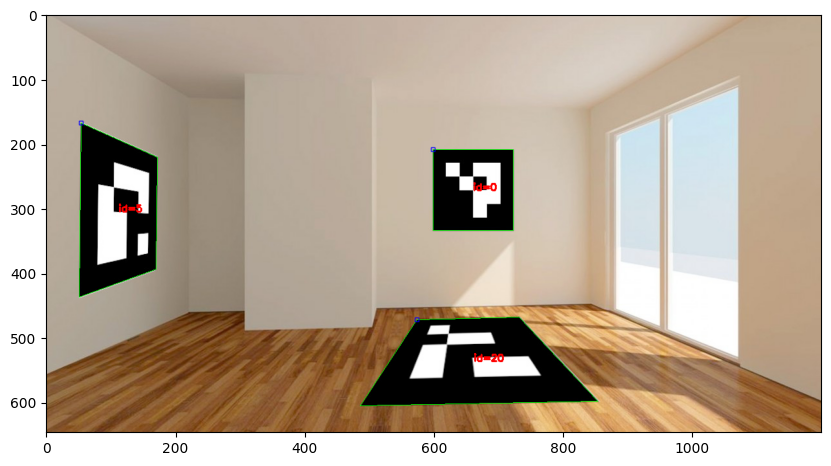

In [2]:

# Image with ArUco
img01 = cv.imread('./images/room03.jpg')

# List of images that will replace the ArUco markers
img_list = ["./images/img01.jpg", 	"./images/img02.jpg", 	"./images/img03.jpg" ]


# Convert to RGB to use with matplotlib
img01_rgb = cv.cvtColor(img01, cv.COLOR_BGR2RGB)

#Load the dictionary that was used to generate the markers.
# Initialize the detector parameters using default values

parameters =  cv.aruco.DetectorParameters()
dictionary = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_4X4_50)
arucoDetector = cv.aruco.ArucoDetector(dictionary, parameters)


# Detect the markers in the image
markerCorners, markerIds, rejectedCandidates = arucoDetector.detectMarkers(img01_rgb)

if markerIds is None:
  print ('No markers detected in the image.')


# Show image with matplotlib
img01_corners = cv.aruco.drawDetectedMarkers(img01_rgb, markerCorners,markerIds)
plt.figure(figsize=[10,10])
plt.imshow(img01_corners)



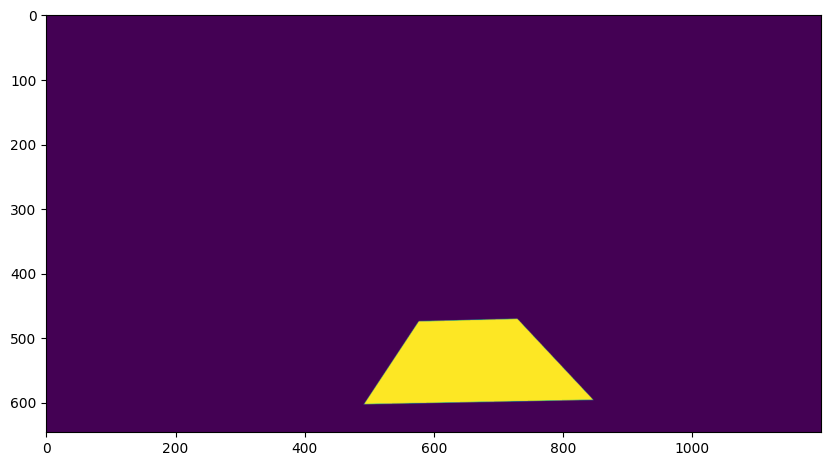

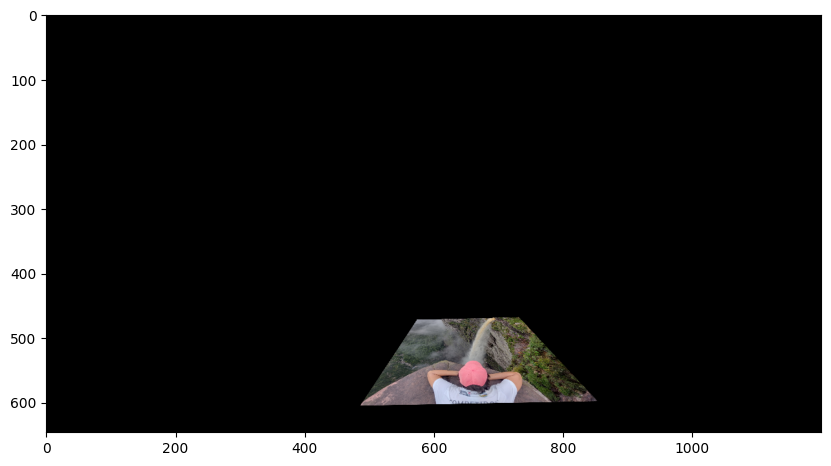

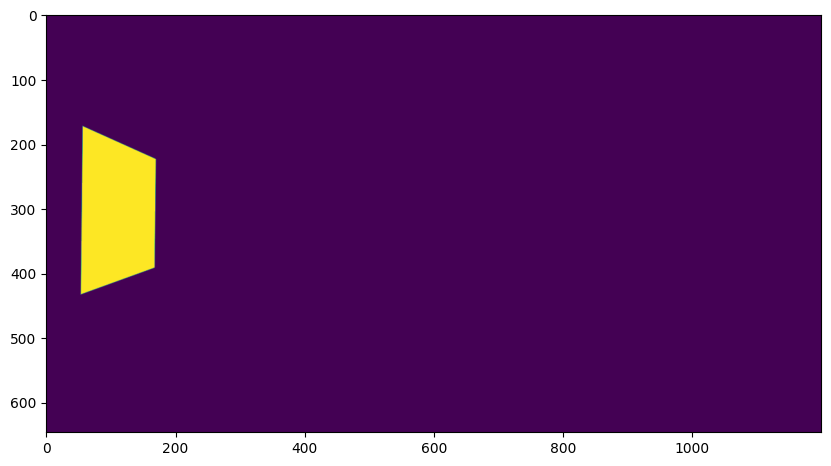

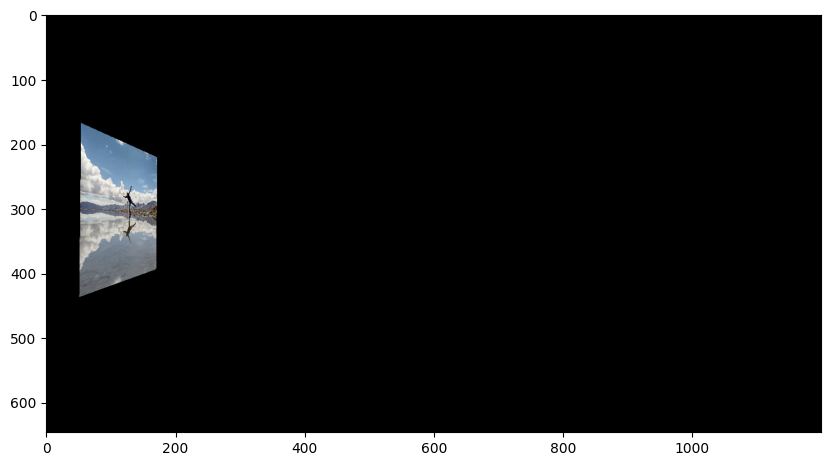

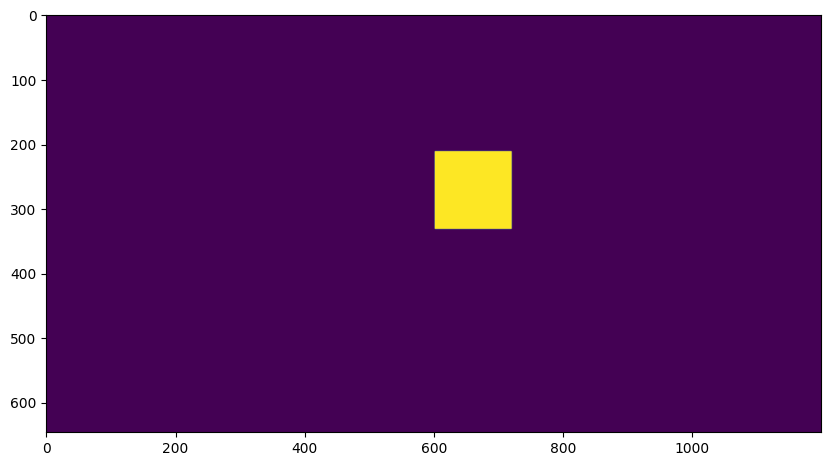

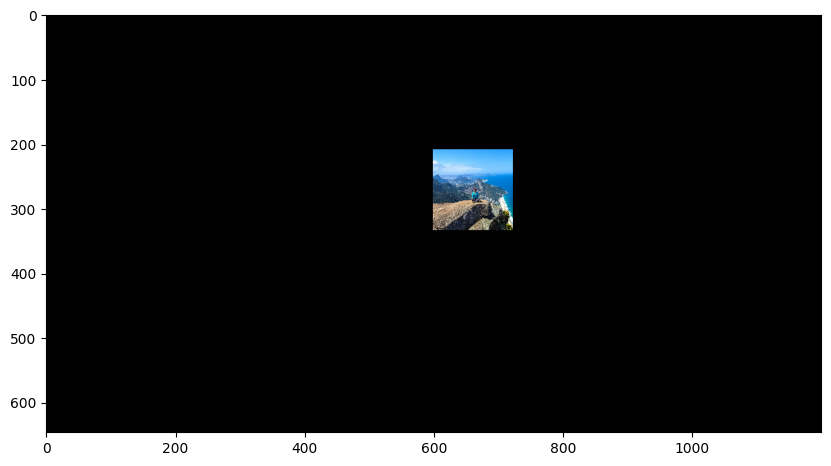

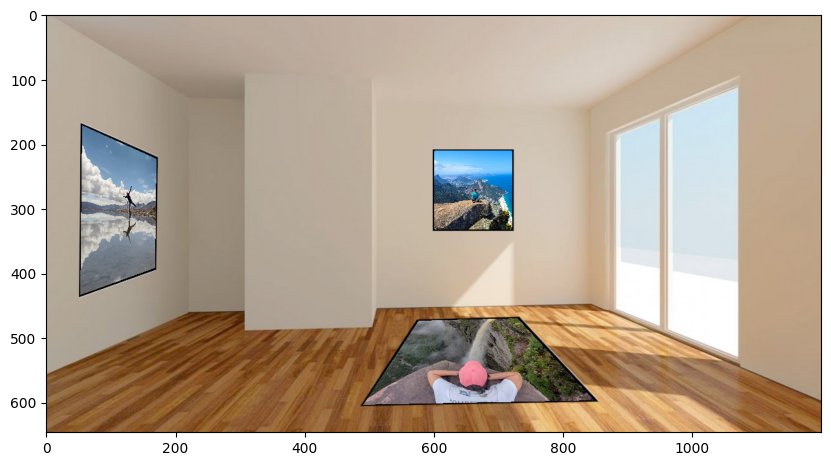

In [3]:
# Flatten the ArUco IDs list
ids = markerIds.flatten()

img_out = cv.cvtColor(img01, cv.COLOR_BGR2RGB)

img_id = 0
# Loop over the detected ArUCo corners
for (markerCorner, markerId) in zip(markerCorners, ids):

  # Read the image in the list
  img = cv.imread(img_list[img_id])
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  # Get the limits of the image
  [l,c,ch] = np.shape(img_rgb)

  # Source points are the corners of the image that will be warped
  pts_src = np.array([[0,0],[c,0],[c,l],[0,l]])

  # Destiny points are the corners of the marker
  pts_dst = markerCorner.reshape((-1, 2))

  # Calculate Homography
  h, status = cv.findHomography(pts_src, pts_dst)

  # Warp source image to destination based on homography
  warped_image = cv.warpPerspective(img_rgb, h, (img01_rgb.shape[1],img01_rgb.shape[0]))

  # Prepare a mask representing region to copy from the warped image into the original frame.
  mask = np.zeros([img01_rgb.shape[0], img01_rgb.shape[1]], dtype=np.uint8)

  # Create a white polygon in the mask to mark the place to insert the image
  cv.fillConvexPoly(mask, np.int32([pts_dst]), (255, 255, 255), cv.LINE_AA)

  # Erode the mask to not copy the boundary effects from the warping
  element = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
  mask = cv.erode(mask, element, iterations=3)
  plt.figure(figsize=[10,10])
  plt.imshow(mask)


  plt.figure(figsize=[10,10])
  plt.imshow(warped_image)

  # Invert the mask for the region you’re overlaying
  mask_inv = cv.bitwise_not(mask)



  # Black out the region on the original frame
  img_out_bg = cv.bitwise_and(img_out, img_out, mask=mask_inv)

  # Take only the region from the warped image
  warped_fg = cv.bitwise_and(warped_image, warped_image, mask=mask)

  # Combine the original image with the warped image
  img_out = cv.add(img_out_bg, warped_fg)

  # Increment the image index
  img_id = img_id + 1


# Show the final result
plt.figure(figsize=[10,10])
plt.imshow(img_out.astype(int))
plt.show()


